<a href="https://colab.research.google.com/github/henrycgbaker/Debt_Settlement_App/blob/main/uncertainty_celeba_TTA_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import ToPILImage, ToTensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
from tqdm import tqdm
import timm
import warnings
import time
import copy


In [37]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

# Dataset
# Download dataset

*(from main script - nothing TTA-specific here)*

In [38]:
# Download dataset with 300 classes and ~9k samples
!gdown 1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7
!unzip -q celeba_300.zip
!rm celeba_300.zip
dataset_dir = "celeba_300"

# Download dataset with 500 classes and ~15k samples
# !gdown 1Z6UMrQwje-D0VvcKPEXUHzuBvWzCMyAh # -- 500 classes
# !unzip -q celeba_500.zip
# !rm celeba_500.zip
# dataset_dir = "celeba_500"

Downloading...
From (original): https://drive.google.com/uc?id=1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7
From (redirected): https://drive.google.com/uc?id=1aRMM1cdvjXv8mke5Dd4hrgHNA3ZTkOc7&confirm=t&uuid=d36e117b-21f9-405a-9274-5afda04dc798
To: /content/celeba_300.zip
100% 66.0M/66.0M [00:00<00:00, 80.3MB/s]
replace celeba_300/dataset_info.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Create dataset

*(from main script - nothing TTA-specific here)*

- NB 2 different pipelines, one that does testing, and one that does training
- training: Carol already done some transformations as form of regularisation
- testing: untouched - TTA we will augment this with transformations

In [39]:
# Dataset and Loader
class CelebADataset(Dataset):
    def __init__(self, metadata, train=True, root_dir=dataset_dir):
        # Initialize dataset
        self.metadata = metadata
        self.root_dir = root_dir
        self.train = train

        # Basic transform for testing
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),    # Resize image to standard input size
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],   # Normalize using ImageNet stats -- MobileNet trained on ImageNet
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Augmented transform for training
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),     # Flip horizontally 50% of time
            transforms.RandomAffine(                    # Stronger geometric transforms
                degrees=(-10, 10),                      # Rotate ±10°
                translate=(0.1, 0.1),                   # Shift up to 10% any direction
                scale=(0.85, 1.15),                     # Scale 85-115% of original
                fill=255                                # Fill edges white
            ),
            transforms.RandomPerspective(               # Perspective warping
                distortion_scale=0.2,                   # Moderate distortion
                p=0.5                                   # 50% chance to apply
            ),
            transforms.ColorJitter(                     # Enhanced color augmentation
                brightness=0.3,                         # ±30% brightness variation
                contrast=0.3,                           # ±30% contrast variation
                saturation=0.2,                         # ±20% saturation variation
            ),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # Slight blur
            transforms.ToTensor(),                      # Convert to tensor
            #transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.02),  # 2% noise
            transforms.RandomErasing(                   # Random patch removal
                p=0.2,                                  # 20% chance to erase
                scale=(0.02, 0.10)                      # Erase 2-15% of image
            ),
            transforms.Normalize(                       # ImageNet normalization
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Access metadata
        img_data = self.metadata[idx]
        img_path = os.path.join(self.root_dir, "images", img_data["img_name"])

        # Load image
        image = Image.open(img_path)

        # Apply appropriate transform
        if self.train:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)

        return image, img_data["identity"]


def create_data_loaders(batch_size=64, train_split=0.8):
    # Load metadata
    info = torch.load(os.path.join(dataset_dir, "dataset_info.pt"))
    metadata = info["metadata"]
    n_classes = info["n_classes"]

    # Calculate splits
    train_size = int(train_split * len(metadata))
    test_size = len(metadata) - train_size

    # Create index splits
    train_indices, test_indices = torch.utils.data.random_split(
        list(range(len(metadata))),
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create metadata splits
    train_metadata = [metadata[i] for i in train_indices]
    test_metadata = [metadata[i] for i in test_indices]

    # Create dataset instances
    train_dataset = CelebADataset(metadata=train_metadata, train=True)
    test_dataset = CelebADataset(metadata=test_metadata, train=False)

    # Create loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    return train_loader, test_loader, n_classes, train_dataset, test_dataset, train_metadata, test_metadata

# Usage
train_loader, test_loader, n_classes, train_dataset, test_dataset, train_metadata, test_metadata = create_data_loaders(batch_size=64)

Training samples: 7230
Testing samples: 1808


<ipython-input-39-c9d434a4e280>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load(os.path.join(dataset_dir, "dataset_info.pt"))


# Define Model Architecture, Training & Evaluation

*(from main script - nothing TTA-specific here)*

`FaceClassifier` class wraps pretrained model

In [40]:
class FaceClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate=0.3):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=num_classes,
            drop_rate=dropout_rate
        )

        # Set dropout rate for all dropout layers
        for m in self.model.modules():
            if isinstance(m, (nn.Dropout, nn.Dropout2d)):
                m.p = dropout_rate

    def enable_dropout(self):
        self.train()
        for m in self.model.modules():
            if isinstance(m, (nn.Dropout, nn.Dropout2d)):
                m.train()

    def forward(self, x):
        return self.model(x)


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return running_loss / len(train_loader), accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    return running_loss / len(test_loader), accuracy

# Load (Pre-trained) Models

*(from main script - nothing TTA-specific here)*



In [41]:
# Download densenet121
!gdown 1b3wlU9TQEWrxHsNRAmgcgDzbWbWun9Zk

Downloading...
From (original): https://drive.google.com/uc?id=1b3wlU9TQEWrxHsNRAmgcgDzbWbWun9Zk
From (redirected): https://drive.google.com/uc?id=1b3wlU9TQEWrxHsNRAmgcgDzbWbWun9Zk&confirm=t&uuid=a771aa25-90ea-459b-bd62-7d6ad9afe64d
To: /content/best_densenet121_model.pt
100% 29.7M/29.7M [00:00<00:00, 91.4MB/s]


In [42]:
def load_saved_model(model_name, model_path, num_classes=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FaceClassifier(model_name, num_classes=num_classes).to(device)

    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Extract the state_dict and metrics
    state_dict = checkpoint['model_state_dict']
    metrics = checkpoint.get('metrics', None)  # Get metrics if they exist

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
    model.eval()  # Set to evaluation mode

    print(f"Model '{model_name}' loaded successfully from {model_path}.")
    return model, metrics

# Paths to saved models
model_names = ['densenet121']

saved_model_paths = {
    "densenet121": "best_densenet121_model.pt"
}

loaded_models = {}
all_metrics = {}  # Dictionary to store metrics for all models

for model_name in model_names:
    model_path = saved_model_paths[model_name]
    model, metrics = load_saved_model(model_name, model_path, num_classes=300)
    loaded_models[model_name] = model
    if metrics:
        all_metrics[model_name] = metrics  # Store metrics if they exist

print("Loaded metrics for models:", list(all_metrics.keys()))

tta_model = loaded_models['densenet121']

Model 'densenet121' loaded successfully from best_densenet121_model.pt.
Loaded metrics for models: ['densenet121']


<ipython-input-42-cd8ed60dd3d7>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


---

*All the above is loading in pretrained models, now we begin TTA work*

## Test-Time Augmentation (TTA)

Here’s how to implement Test-Time Augmentation (TTA) for uncertainty estimation using a pre-trained model. TTA involves applying augmentations to the input image during inference and analyzing the variability in predictions. This variability provides insight into the model’s uncertainty regarding the input (Aleatoric uncertainty).

Here, uncertainty is the standard deviation of predictions across augmented images. We also delve into other metrics of model calibration.

Steps:

- **Generate predictions for each augmentation:** - Apply a set of predefined augmentations (e.g., rotation, flipping, scaling, etc.) to the input image. Run each augmented version through the pre-trained model to generate predictions for each transformed image.
- **Aggregate Predictions into a Probability Distribution for Each Input**: For each input image, aggregate the model's predictions across all augmented versions. This results in a probability distribution that reflects the model’s predictions for the input, considering various transformations of the data.
- **Calculate Standard Deviation for Uncertainty**: The standard deviation of the aggregated predictions across all augmented images provides a measure of uncertainty.

*NB haven't implemented further than this  in this script. In subsequent scripts:*
- **Class-Specific Aggregation**: Since we have a multi-class problems, aggregate predictions across augmentations for each class separately. This gives a distribution for each class, which can be used to evaluate uncertainty for specific categories.

- **Further analytics**?? Model-specific - this is just calibration?

## Levels of aggregation:
1. raw outputs from uncertainty methods: multiple predictions for each data point
2. aggregate by data point: get uncertainty for each data point
3. aggregate by class: get uncertainty for each class
4. aggregate to model: discuss model calibration

**Uncertainty Metrics** *i.e. additional to accuracy & loss etc*
- prediction variance (std dev)
- entropy (ECE, MCE)
- calibration

# 1) Define TTA Transformations

These are the core transformations to the inputs that we will add to the test-data.

At testing, we run inference on each randomly augmented version of each data point, to obtain a softmax output for that augmentation. We aggregate (mean) these softmax outputs and calculate not just the final prediction, but also the prediction variance across each class across augmentations of a given image.

Note, each augmentation is a stochastic process; this is important as the variability in predictions across augmentations reflects the model's confidence and sensitivity.

Here we define weak, medium and strong versions of the transformations - depending on the use case, different degrees of transofrmation will be optimal. For face classification models such as ours, non-aggressive augmentations are most appropriate; it will be an empirical matter to determine which strength here is most suitable. We have provided a tool box for more aggressive transformations should they be required.



In [ ]:
def get_tta_transforms(strength):
    if strength == 'weak':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.7),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
        ])
    elif strength == 'medium':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.8),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomCrop(size=(200, 200), pad_if_needed=True, padding_mode='reflect'),
            transforms.RandomErasing(p=0.5, scale=(0.01, 0.09), ratio=(0.3, 3.0)),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
        ])
    elif strength == 'strong':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.RandomCrop(size=(180, 180), pad_if_needed=True, padding_mode='reflect'),
            transforms.RandomErasing(p=0.6, scale=(0.05, 0.15), ratio=(0.3, 2.5)),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
        ])


#really extreme transformations if needed:

"""
def get_tta_transforms(strength):
    if strength == 'weak':
        return transforms.Compose([
            transforms.RandomRotation(degrees=20),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.7),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ])

    elif strength == 'medium':
        return transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomAffine(degrees=30, translate=(0.1,0.1), scale=(0.8,1.2), shear=(10,10,10,10)),
                transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
            ]),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.15),
            transforms.RandomApply([transforms.RandomErasing(scale=(0.02,0.1))], p=0.5),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ])

    elif strength == 'strong':
        return transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomAffine(
                    degrees=45,
                    translate=(0.2, 0.2),
                    scale=(0.5, 1.5),
                    shear=(20, 20, 20, 20)
                ),
                transforms.RandomPerspective(distortion_scale=0.9, p=1.0)
            ]),
            transforms.RandomChoice([
                transforms.RandomRotation(degrees=45),
                transforms.RandomResizedCrop(size=(224,224), scale=(0.5,1.0), ratio=(0.5,2.0))
            ]),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.2),
            transforms.RandomApply([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()], p=0.7),
            transforms.RandomApply([transforms.RandomErasing(scale=(0.05,0.2))], p=0.5),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ])
"""

# usage:
tta_transform_weak = get_tta_transforms('weak')
tta_transform_medium = get_tta_transforms('medium')
tta_transform_strong = get_tta_transforms('strong')


# 2) Modify the Test Dataset

Having defined the augmentations above, below we apply them to our test data.

To do this we need to make modifications from the custom parent class of our original dataset `CelebADataset`. We call this new class `CelebADataset_tta` - it is identical to its parent class, except that it includes the option to apply augmentations to the test data.

We then create `test_loader_tta` dataloaders based on the modified `CelebADataset_tta`. To do so we use a custom `create_data_loaders_tta() function.

We provide the tools for this modular workflow to build up intuition in the tutorial, however for practical purposes we then go on to provide an end-to-end workflow that could be used by policy analysts on a raw (image) dataset. This in-line workflow is recommended.

## Create custom `CelebADataset_tta` class and `create_data_loaders_tta()` function.

In [44]:
# extend on parent class `CelebADataset`

class CelebADataset_tta(CelebADataset):
    def __init__(self, metadata, root_dir=dataset_dir, tta_augment=True, tta_transform=tta_transform_strong, tta_count=5):
        super().__init__(metadata=metadata, train=False, root_dir=root_dir)  # train=False ensures test behavior
        self.tta_augment = tta_augment
        self.tta_transform = tta_transform
        self.tta_count = tta_count

    def __getitem__(self, idx):
        img_data = self.metadata[idx]
        img_path = os.path.join(self.root_dir, "images", img_data["img_name"])
        image = Image.open(img_path).convert("RGB")

        augmentations = []
        if self.tta_augment:
            # Convert the image to a tensor before applying augmentations
            image_tensor = transforms.ToTensor()(image)
            for _ in range(self.tta_count):
                # Apply the augmentation to the tensor
                aug_img = self.tta_transform(image_tensor)
                augmentations.append(aug_img)
        else:
            # test_transform should also return a Tensor
            augmentations = [self.test_transform(image)]

        return augmentations, img_data["identity"]

def create_data_loaders_tta(batch_size=64, train_split=0.8, tta_count=5):
    # call original function to get shared components
    train_loader, test_loader, n_classes, train_dataset, test_dataset, train_metadata, test_metadata = create_data_loaders(
        batch_size=batch_size, train_split=train_split
    ) #NB we won't use the test_loader or test_dataset from here

    # replace test dataset with the TTA-enabled dataset
    test_dataset_tta = CelebADataset_tta(metadata=test_metadata, tta_count=tta_count)

    # create additional TTA-enabled test loader
    test_loader_tta = DataLoader(
        test_dataset_tta,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=tta_collate_fn  # collate function for handling augmentations
    )

    print(f"Testing samples with TTA: {len(test_dataset_tta)} (each with {tta_count} augmentations)")

    return train_loader, test_loader_tta, n_classes, train_dataset, test_dataset_tta, train_metadata, test_metadata


def tta_collate_fn(batch):
    augmentations, labels = zip(*batch)  # separate augmentations + labels
    # flatten augs
    augmentations = [aug for group in augmentations for aug in group]
    # duplicate labels
    tta_count = len(augmentations) // len(labels)
    labels = [label for label in labels for _ in range(tta_count)]

    # turn into tensors
    # ensure each 'aug' is a Tensor. If they are not, torch.stack will fail.
    return torch.stack(augmentations), torch.tensor(labels)


In [45]:
# Usage

transformation_strengths = ['weak', 'medium', 'strong']

# Initialize dictionaries to hold datasets and loaders
augmented_datasets = {}
augmented_loaders = {}

for strength in transformation_strengths:
    tta_transform = get_tta_transforms(strength)

    # Create the augmented dataset
    dataset_aug = CelebADataset_tta(
        metadata=test_metadata,
        root_dir=dataset_dir,
        tta_transform=tta_transform
    )

    augmented_datasets[strength] = dataset_aug

    loader_aug = DataLoader(
        dataset_aug,
        batch_size=64,
        shuffle=False,
        num_workers=2
    )
    augmented_loaders[strength] = loader_aug

    print(f"{strength.capitalize()}ly Augmented Test Samples: {len(dataset_aug)}")


Weakly Augmented Test Samples: 1808
Mediumly Augmented Test Samples: 1808
Strongly Augmented Test Samples: 1808


Here we have augmented each of images 5 times and saved

(Weak augmentation)


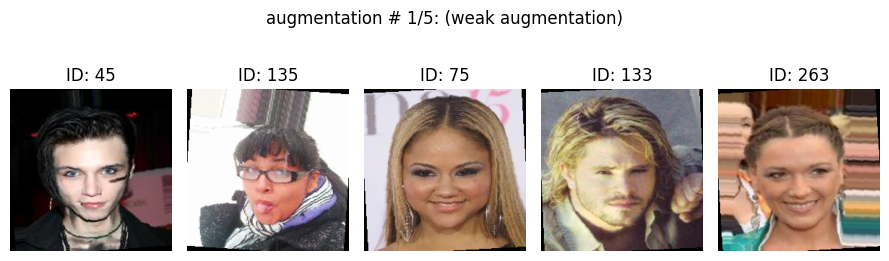

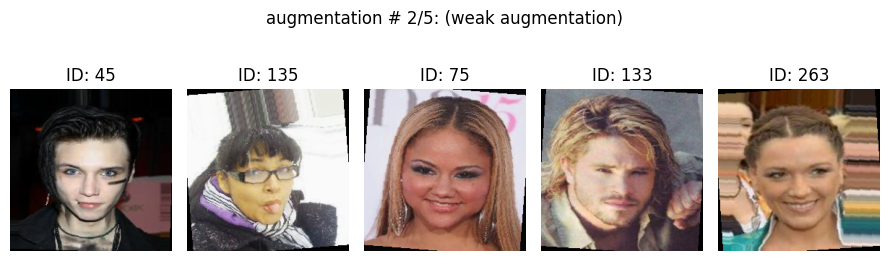

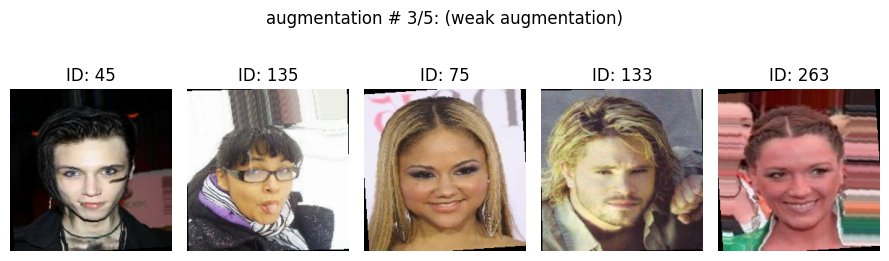

(Medium augmentation)


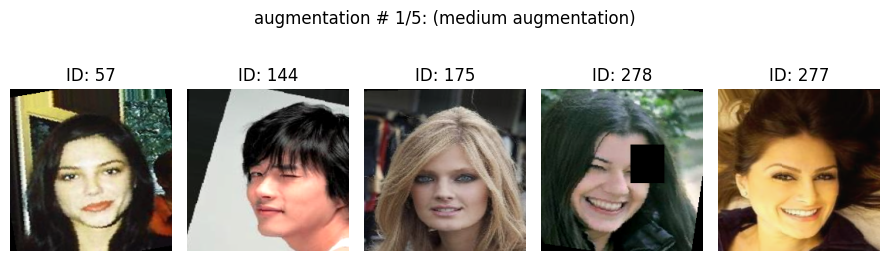

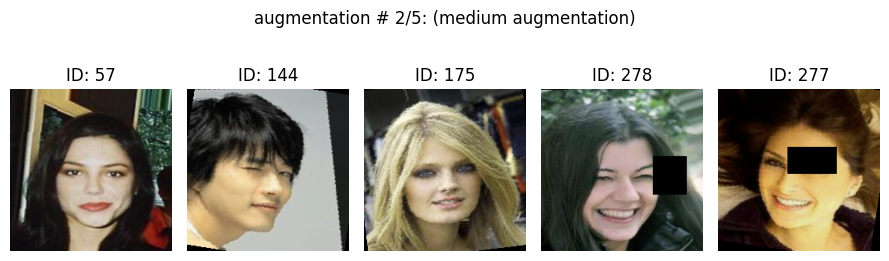

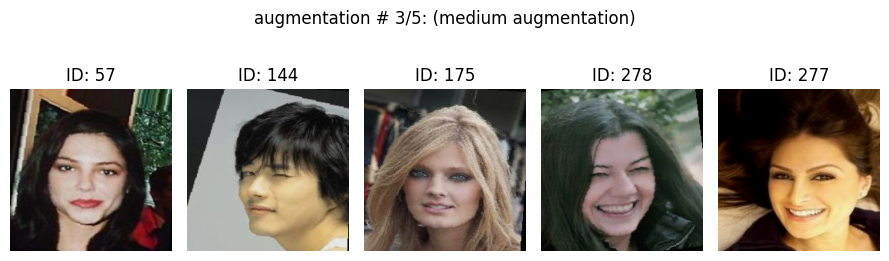

(Strong augmentation)


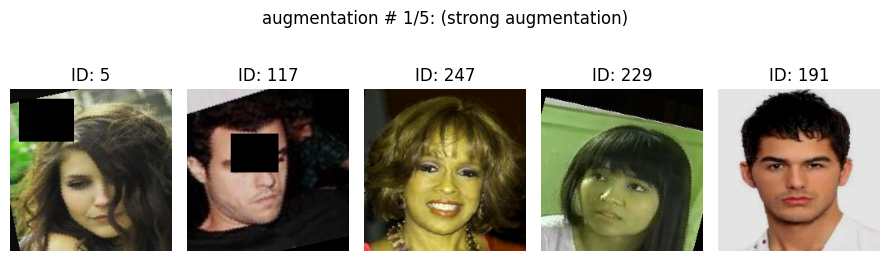

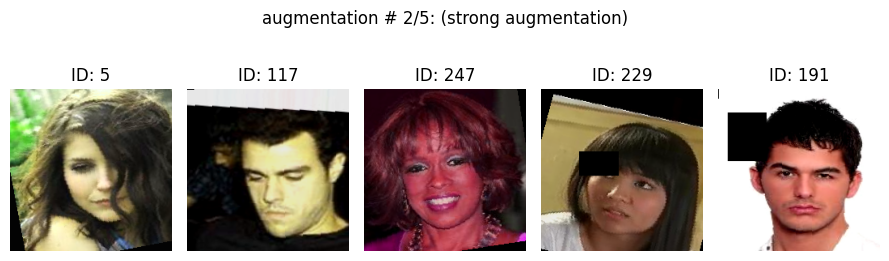

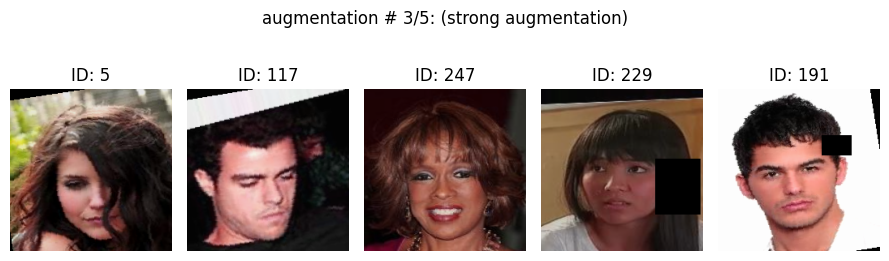

In [46]:
def visualize_dataset(dataset, title, start_idx=0, num_images=5, tta_idx = 0):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    plt.figure(figsize=(9, 3))
    for i in range(start_idx, start_idx + num_images):
        if i >= len(dataset):
            break  # Prevent indexing beyond dataset size
        image, label = dataset[i] # get list of images
        image = image[tta_idx]# take the first image for visualization

        # check if image is Tensor
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image) # convert to Tensor if necessary

        image = image.clone()
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
        image = image.permute(1, 2, 0).cpu().numpy().clip(0, 1)
        plt.subplot(1, num_images, i - start_idx + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"ID: {label}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# starting indices for each dataset
start_indices = {
    'weak': 0,
    'medium': 5,
    'strong': 10
}

# Combined loop for visualizing augmentations in sequence
tta_idx_to_display = 3

for strength in transformation_strengths:
    print(f"({strength.capitalize()} augmentation)")
    start_idx = start_indices[strength]
    for i in range(tta_idx_to_display):
            dataset = augmented_datasets[strength]
            title = f"augmentation # {i + 1}/5: ({strength} augmentation)"
            visualize_dataset(dataset, title, start_idx=start_idx, num_images=5, tta_idx=i)



### warning:
NB: below code I can't get to run (there's an issue with feeding a list to the `inputs=inputs.to(device)`. It's a list because im collecting the different augmentations together to try to then avg the predictions + calclate prediction variance, but I can't figure out how to get it to run.

It's not a big issue, below I'm running an in-line function that does this all on an non-augmented dataset. Maybe delete the below?

# Running augmentations on a single image to guage prediction instability

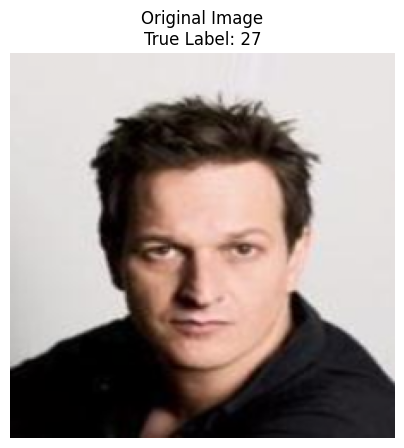

In [47]:
# Set up
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_idx = 37
image, true_label = test_dataset[sample_idx]
image = image.to(device)

transformation_strengths = ['weak', 'medium', 'strong']
tta_transforms = {
    'weak': tta_transform_weak,
    'medium': tta_transform_medium,
    'strong': tta_transform_strong
}
augs = 100

# Normalisation parameters for renormalisation
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)

# Function to denormalise the image
def denormalise(image, mean, std):
    image = image.clone()
    image = image * std + mean
    return image

# Renormalise and plot the original image
renormalised_image = denormalise(image, mean, std).permute(1, 2, 0).cpu().numpy().clip(0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(renormalised_image)
plt.title(f'Original Image\nTrue Label: {true_label}')
plt.axis('off')
plt.show()

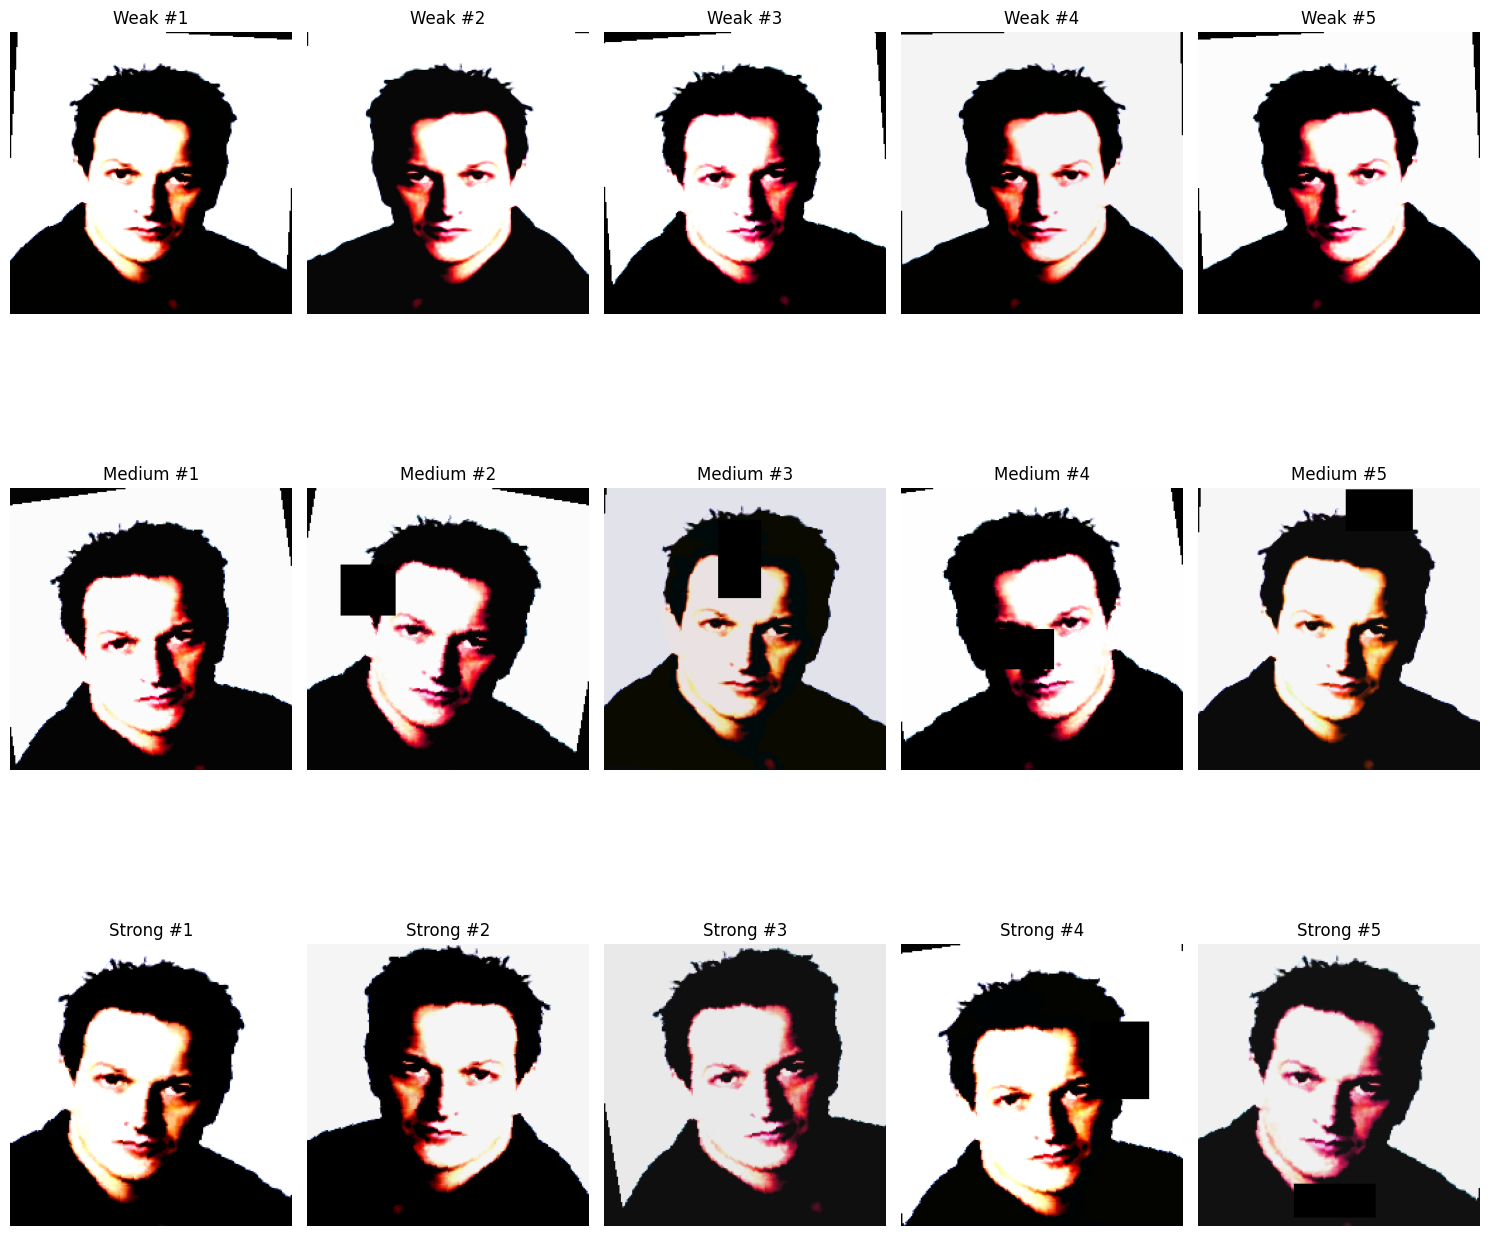

In [48]:
# plot augmented images

import random

# Create subplot grid
n_strengths = len(transformation_strengths)
fig = plt.figure(figsize=(15, 5 * n_strengths))

for strength_idx, strength in enumerate(transformation_strengths):
    # Set transformation strength
    tta_transform = tta_transforms[strength]

    # Collect augmented images
    augmented_images = []
    with torch.no_grad():
        for _ in range(augs):
            aug_image = tta_transform(image)
            augmented_images.append(aug_image)

    # Sample a few augmentations for visualisation
    sampled_augs = random.sample(augmented_images, 5)  # Randomly sample 5 images

    # Display sampled augmentations
    for aug_idx, aug_image in enumerate(sampled_augs):
        # Add subplot
        plt.subplot(n_strengths, 5, strength_idx * 5 + aug_idx + 1)
        # Denormalise the image
        renormalised_image = denormalise(aug_image, mean, std).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        # Plot the image
        plt.imshow(renormalised_image)
        plt.title(f'{strength.capitalize()} #{aug_idx + 1}')
        plt.axis('off')

plt.tight_layout()
plt.show()

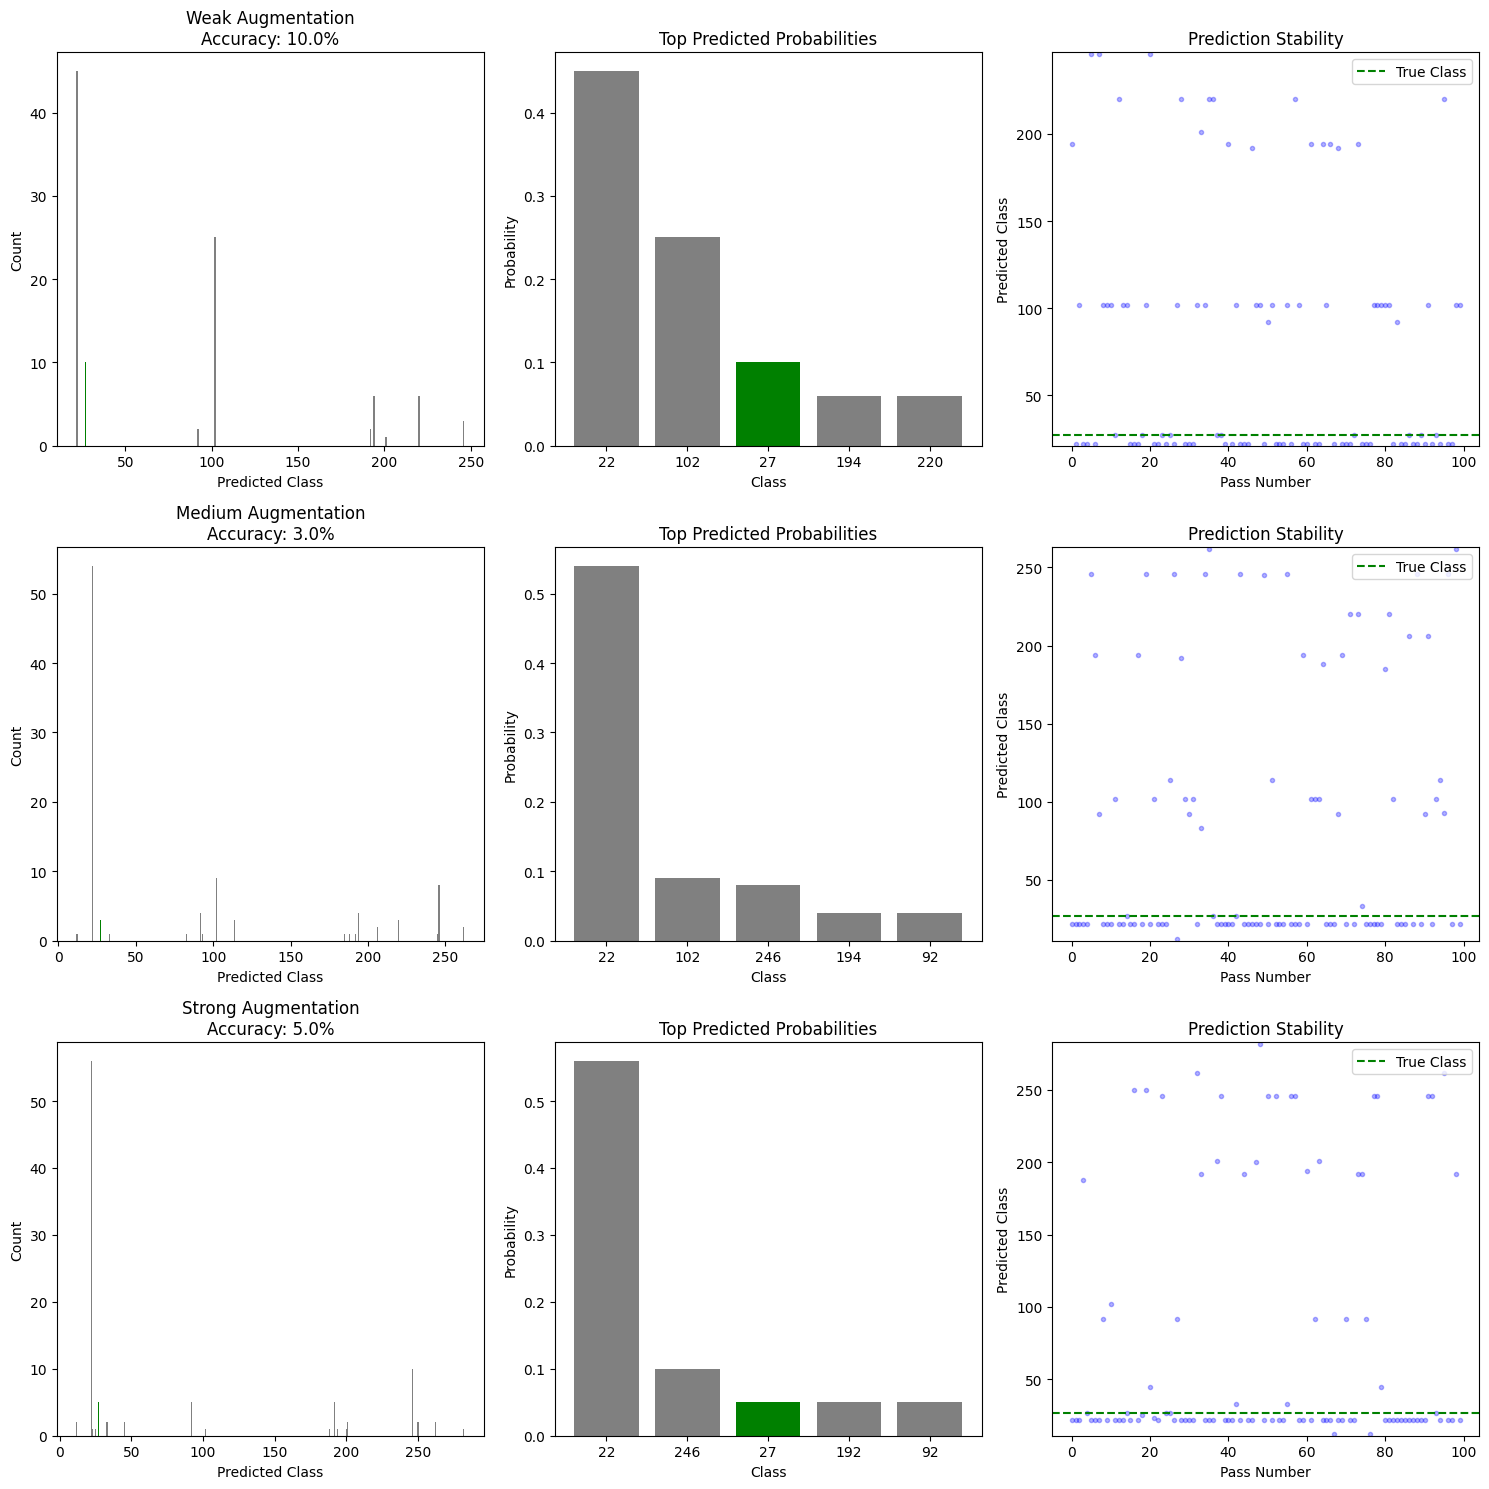

In [49]:
# plot the prediction variance

# Create subplot grid for metrics
fig = plt.figure(figsize=(15, 5 * n_strengths))

for strength_idx, strength in enumerate(transformation_strengths):
    # Set transformation strength
    tta_transform = tta_transforms[strength]

    # Collect predictions
    predictions = []
    with torch.no_grad():
        for _ in range(augs):
            aug_image = tta_transform(image)
            outputs = tta_model(aug_image.unsqueeze(0))
            pred = torch.argmax(outputs)
            predictions.append(pred.cpu().item())

    # Calculate statistics
    unique_preds, counts = np.unique(predictions, return_counts=True)
    pred_probs = counts / augs
    n_top = min(5, len(unique_preds))  # ensure at least 5 for plotting
    top_indices = np.argsort(pred_probs)[-n_top:][::-1]
    top_classes = unique_preds[top_indices]
    top_probs = pred_probs[top_indices]
    accuracy = (np.array(predictions) == true_label).mean() * 100

    # Plot prediction distribution
    plt.subplot(n_strengths, 3, strength_idx * 3 + 1)
    colors = ['green' if pred == true_label else 'gray' for pred in unique_preds]
    plt.bar(unique_preds, counts, color=colors)
    plt.title(f'{strength.capitalize()} Augmentation\nAccuracy: {accuracy:.1f}%')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')

    # Plot top probabilities
    plt.subplot(n_strengths, 3, strength_idx * 3 + 2)
    colors = ['green' if cls == true_label else 'gray' for cls in top_classes]
    plt.bar(range(n_top), top_probs, color=colors)
    plt.title('Top Predicted Probabilities')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.xticks(range(n_top), top_classes)

    # Plot prediction stability
    plt.subplot(n_strengths, 3, strength_idx * 3 + 3)
    plt.plot(range(augs), predictions, 'b.', alpha=0.3)
    plt.axhline(y=true_label, color='g', linestyle='--', label='True Class')
    plt.title('Prediction Stability')
    plt.xlabel('Pass Number')
    plt.ylabel('Predicted Class')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.ylim(min(predictions) - 1, max(predictions) + 1)

plt.tight_layout()
plt.show()


There is clearly something wrong with how the augmentations are being applied

## Create custom `evaluate_with_tta()` function

*NB; this doesn't work, but we can bin it if short of time (nice-to-have)*

In [50]:
def evaluate_tta_preaugmented(model, test_loader, criterion, device, tta_count=5):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    prediction_variations = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating with pre-augmented data"):
            # Here, inputs and labels are already tensors due to the collate_fn
            inputs = inputs.to(device)   # should work now since inputs is a Tensor
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)  # [batch_size * tta_count, num_classes]

            # Compute loss directly
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute probabilities
            probs = F.softmax(outputs, dim=1)  # [batch_size * tta_count, num_classes]

            # Determine original batch_size
            batch_size = labels.size(0) // tta_count

            # Reshape for TTA aggregation
            probs = probs.view(batch_size, tta_count, -1)  # [batch_size, tta_count, num_classes]
            std_probs = probs.std(dim=1)
            mean_probs = probs.mean(dim=1)  # [batch_size, num_classes]

            # Extract the original labels from the repeated ones
            unique_labels = labels.view(batch_size, tta_count)[:, 0]

            # Accuracy
            _, predicted = mean_probs.max(1)
            correct += predicted.eq(unique_labels).sum().item()
            total += batch_size

            # Store results
            all_labels.extend(unique_labels.cpu().numpy())
            all_predictions.append(mean_probs.cpu().numpy())
            prediction_variations.append(std_probs.cpu().numpy())

    accuracy = 100.0 * correct / total
    average_loss = running_loss / len(test_loader)
    all_predictions = np.concatenate(all_predictions, axis=0)
    prediction_variations = np.concatenate(prediction_variations, axis=0)

    return average_loss, accuracy, all_predictions, np.array(all_labels), prediction_variations


In [51]:
def log_and_visualise_uncertainty(prediction_variations, all_predictions, all_labels):
    # Histogram of uncertainty
    stds = prediction_variations.flatten()
    plt.figure()
    sns.histplot(stds, bins=30, kde=True)
    plt.title("Uncertainty Distribution (Standard Deviations)")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()

    # Per-class uncertainty
    for class_idx in range(all_predictions.shape[1]):
        class_stds = prediction_variations[all_labels == class_idx]
        plt.figure()
        sns.histplot(class_stds.flatten(), bins=30, kde=True)
        plt.title(f"Uncertainty Distribution for Class {class_idx}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.show()


Call new `evaluate_tta_preaugmented()` workflow on the DesNet model

In [52]:
"""
# model = FaceClassifier('densenet121', num_classes=num_classes).to(device) # ALREADY DEFINED

results = {}

# iter through the augmented_loaders dictionary
for strength, loader in augmented_loaders.items():
    test_loss, test_accuracy, all_preds, all_labels = evaluate_tta_preaugmented(
        model=model,
        test_loader=loader,
        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    # store results in dict
    results[strength] = {
        "avg_test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "all_predictions": all_preds,
        "all_labels": all_labels,
        "prediction_variations": prediction_variations
    }

    print(f"Transformation strength: {strength.capitalize()}:")
    print(f"Test Loss: {test_loss:.4f}, TTA Test Accuracy: {test_accuracy:.2f}%\n")
"""

'\n# model = FaceClassifier(\'densenet121\', num_classes=num_classes).to(device) # ALREADY DEFINED\n\nresults = {}\n\n# iter through the augmented_loaders dictionary\nfor strength, loader in augmented_loaders.items():\n    test_loss, test_accuracy, all_preds, all_labels = evaluate_tta_preaugmented(\n        model=model,\n        test_loader=loader,\n        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),\n        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),\n    )\n\n    # store results in dict\n    results[strength] = {\n        "avg_test_loss": test_loss,\n        "test_accuracy": test_accuracy,\n        "all_predictions": all_preds,\n        "all_labels": all_labels,\n        "prediction_variations": prediction_variations\n    }\n\n    print(f"Transformation strength: {strength.capitalize()}:")\n    print(f"Test Loss: {test_loss:.4f}, TTA Test Accuracy: {test_accuracy:.2f}%\n")\n'

## Warning (continued)

the above code doesn't run - i have gone over it so many times, but can't get it to work. Ultimately we don't need it as the below wrapper function does it all in line, Maybe we just keep the but that vizialises the images (and maybe we print out some more of the augmented images) to give intuition of what's going on underneath the hood, but then remove the part where we try to run inference on the augemented datasets, and just rely on the below workflow which does it all in-line?

# Creating a wrapper function for End-2-End workflow for anon-augmented dataset



Whereas the above workflow performed test data augmentation out-of-function to demonstrate intuitively what is happeneing to the input images in TTA, in reality, for policy analysts it is preferable to have an out-of-box usable function that can be called on a non-augmented dataset and augments test data in-function.

Here we create an all-in-one workflow that can be applied to a raw (image) dataset.

The `evaluate_tta_e2e` function performs an end-to-end evaluation of a model using TTA. This approach introduces diversity during testing by applying stochastic augmentations to each input multiple times (tta_count). The augmented inputs are passed through the model, and their predictions (softmax probabilities) are aggregated (via mean) to form a robust final prediction. The function also computes uncertainty metrics by measuring prediction variation (standard deviation of class probabilities across augmentations). These variations provide insights into the model's sensitivity to changes in input data and its confidence in predictions.

Additionally, it computes Expected Calibration Error (ECE) and Maximum Calibration Error (MCE) to evaluate how well the model's predicted confidences align with actual accuracies.

To ensure ease of use, the function takes raw, unaugmented data from a test_loader, applies transformations within the function (if `tta_augment` is enabled; NB `tta_count` is a tunable hyperparameter), and returns comprehensive outputs. This eliminates the need for preprocessing the test data externally, making it a practical out-of-the-box solution for policy analysts and practitioners.



In [58]:
def evaluate_tta_e2e(
    model,
    test_loader,
    device,
    tta_count=5,
    tta_augment=True,
    tta_transform=None
):
    """
    evals a model using (TTA).

    Parameters
    ----------
    model : torch.nn.Module
        The model to evaluate.
    test_loader : torch.utils.data.DataLoader
        DataLoader providing the test set.
    device : torch.device
        The device (CPU/GPU) to run the evaluations on.
    tta_count : int, optional
        Number of augmented variants to generate per input (default=5).
    tta_augment : bool, optional
        Whether to apply TTA augmentations (default=True).
    tta_transform : callable, optional
        A function/transform that takes a tensor image and returns an augmented version.
        Required if tta_augment is True.

    Returns
    -------
    average_loss : float
        Average loss over the test set with TTA.
    accuracy : float
        Classification accuracy (%).
    all_predictions : np.ndarray
        Array of mean class probabilities for each test example (shape: [N, num_classes]).
    all_labels : np.ndarray
        Ground truth labels for each test example (shape: [N,]).
    prediction_variations : np.ndarray
        Array of standard deviations of the class probabilities for each test example
        across TTA samples (shape: [N, num_classes]).
    ece : float
        Expected Calibration Error.
    mce : float
        Maximum Calibration Error.
    """
    if tta_augment and tta_transform is None:
        raise ValueError("TTA augmentation is enabled, but no TTA transform is provided.")

    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    prediction_variations = []
    confidence_scores = []
    accuracy_flags = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating with TTA"):

            inputs = inputs.to(device)
            labels = labels.to(device)

            batch_size = inputs.size(0)
            all_labels.extend(labels.cpu().numpy())

            # creaate TTA batch by repeating the inputs tta_count times
            # original shape: (batch_size, C, H, W)
            # after repeat: (batch_size * tta_count, C, H, W)
            inputs_tta = inputs.unsqueeze(1).expand(-1, tta_count, -1, -1, -1)
            inputs_tta = inputs_tta.contiguous().view(-1, inputs.size(1), inputs.size(2), inputs.size(3))

            # apply TTA transform if specified
            if tta_augment:
                inputs_tta_list = [tta_transform(img) for img in inputs_tta]
                inputs_tta = torch.stack(inputs_tta_list).to(device)

            # forward pass
            # shape: (batch_size * tta_count, num_classes)
            outputs = model(inputs_tta)

            # Convert outputs to probabilities
            probs = F.softmax(outputs, dim=1)
            # Reshape to (batch_size, tta_count, num_classes)
            probs = probs.view(batch_size, tta_count, -1)

            #  mean and std of predictions across TTA samples
            mean_probs = probs.mean(dim=1)  # shape: (batch_size, num_classes)
            std_probs = probs.std(dim=1)

            # loss on mean predictions (convert mean_probs to log_probs)
            loss = F.nll_loss(torch.log(mean_probs), labels)
            running_loss += loss.item()

            # predicted classes and their confidence
            confidences, predicted = mean_probs.max(dim=1)
            confidence_scores.extend(confidences.cpu().numpy())

            # chec correctness
            accuracy_flags_batch = predicted.eq(labels).cpu().numpy().flatten().tolist()
            accuracy_flags.extend(accuracy_flags_batch)
            correct += sum(accuracy_flags_batch)
            total += batch_size

            all_predictions.append(mean_probs.cpu().numpy())
            prediction_variations.append(std_probs.cpu().numpy())

    # aggregate metrics
    accuracy = 100.0 * correct / total
    average_loss = running_loss / len(test_loader)

    # lists to numpy arrays
    all_predictions = np.concatenate(all_predictions, axis=0)
    prediction_variations = np.concatenate(prediction_variations, axis=0)
    all_labels = np.array(all_labels)

    # calibration errors
    ece, mce = calculate_calibration_error(confidence_scores, accuracy_flags)

    return average_loss, accuracy, all_predictions, all_labels, prediction_variations, ece, mce


Now we run the end-to-end TTA process with a range of `tta_count` values and `tta_transform` strengths to explore the trade-off between `test_accuracy` and `prediction_variation`, aiming to effectively quantify uncertainty. Doing so is essential to calibrate the model's predictions while maintaining robust performance (?).

If accuracy is too low—due to overly aggressive transformations or inherent model limitations, then prediction variation may increase across all inputs. However, this variation reflects poor task alignment rather than meaningful uncertainty, making the analysis less insightful.

If the model achieves very high accuracy and the augmentations are too weak to induce noticeable prediction variability, the uncertainty analysis may lack depth, as the model's predictions remain overly confident and invariant to perturbations.

We want to strike a balance: introducing augmentations that mimic realistic variability while ensuring the model retains sufficient performance to produce interpretable results. This balance allows prediction variation to meaningfully reflect the model's sensitivity to input changes, revealing areas of uncertainty or robustness.

To complement this, **Expected Calibration Error (ECE)** and **Maximum Calibration Error (MCE)** are calculated to evaluate the alignment between predicted confidence and actual accuracy. These metrics ensure that uncertainty scores are not only measurable but also reliable, providing additional insights into the model’s behaviour under TTA.

By tuning the TTA parameters provided, analysts can achieve a robust analysis of model uncertainty and confidence calibration.

In [57]:
# Usage
# model already defined, for reference: model= FaceClassifier('densenet121', num_classes=num_classes).to(device)

tta_values = [5, 7, 10]
transformation_strengths = ['weak', 'medium', 'strong']

tta_transforms = {
    'weak': tta_transform_weak,
    'medium': tta_transform_medium,
    'strong': tta_transform_strong
}

results = {}

for strength in transformation_strengths:
    for tta_value in tta_values:

        tta_transform = tta_transforms[strength]

        test_loss, test_accuracy, all_preds, all_labels, prediction_variations, ece, mce = evaluate_tta_e2e(
            model=tta_model,
            test_loader=test_loader,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
            tta_augment=True,
            tta_count=tta_value,
            tta_transform=tta_transform
        )

        # Store the results in the dictionary
        results[(strength, tta_value)] = {
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "all_predictions": all_preds,
            "all_labels": all_labels,
            "prediction_variations": prediction_variations,
            'ECE': ece,
            'MCE': mce
        }

        print(f"Augs per image (tta_count): {tta_value}, transformations: {strength}:")
        print(f"    Mean Test Loss (NLLLoss): {test_loss:.2f}")
        print(f"    TTA Test Accuracy: {test_accuracy:.2f}%")
        print(f"    Mean Prediction Variations (mean std dev): {prediction_variations.mean():.2f}")
        print(f"    ECE: {ece:.2f}")
        print(f"    MCE: {mce:.2f}")

Evaluating with TTA:   0%|          | 0/29 [00:05<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# Select `augmentation_strenth` & `tta_count` value to use:

- we should avoid configurations where accuracy drops excessively due to overly strong augmentations or an inflated `tta_count`.
- assess whether the variation is informative (i.e., highlights uncertainty in challenging examples) rather than reflecting randomness or overly aggressive augmentations.
    - too high variation across all samples may indicate that the augmentations are unrealistic.
    - too low variation suggests the model is overconfident or that augmentations are too weak.
- ECE and MCE: choose configurations with lower ECE and MCE, indicating that the model’s predicted confidence aligns well with actual accuracy.
- Test the chosen configuration on challenging cases: do the prediction variations align with your expectations of uncertainty (e.g., ambiguous faces should show higher uncertainty)?

---


### 3) Calcualte Uncertainty Metrics

With multiple predictions per image, we can compute uncertainty metrics such as:

Prediction Entropy: Measures the uncertainty in the predicted probability distribution.
Prediction Variance: Measures the variability in predictions across augmentations.

is this right?

### 4) Visualise Uncertainty Distributions

- Entropy Distribution: Compare entropy for correct vs. incorrect predictions.
- Confidence Distribution: Similar to entropy.
- Calibration Plot: Shows how confidence aligns with accuracy.
- Confusion Matrix with Uncertainty: Visualize uncertainty per class.

First, Prep Data:

come back to: add standard deveiation / variance measures

#### i) Entropy Distribution
- Lower Entropy: Indicates higher confidence.
- Higher Entropy: Indicates more uncertainty.
- Compare: Correct predictions typically have lower entropy.